<a href="https://colab.research.google.com/github/kaifoerster/ML_Lab_1_Group-A/blob/main/Lab_Sesssion_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.3 -q


In [ ]:
import collections
import math
import torch
import re
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


%matplotlib inline

##Implementing RNN
We define a vanilla RNN with three parameters:

- $W_{x}$: the weight matrix multiplying input $X_t$
- $W_{h}$: the weight matrix multiplying hidden state $H_{t-1}$
- $b$: the bias of the hidden state.

Altogether, the class applies the following recursion:

$f(X_t) = \phi(W_x X_t + W_h H_{t-1}+b) =  \phi\bigg(W_x X_t + W_h \phi(W_x X_{t-1} + W_h H_{t-2} +b )+b\bigg) = \dots $

In [ ]:
class RNN(d2l.Module):

    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        # Weight matrix that multiplies input X_t
        self.W_x = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)

        # Weight matrix that multiplies output of hidden state H_(t-1)
        self.W_h = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)

        #Bias of the hidden state
        self.b = nn.Parameter(torch.zeros(num_hiddens))

        #Activation function of the hidden layer
        self.activation_func = torch.tanh

    def forward(self, inputs, state=None):
      """Executes the RNN recurrent step.
      Inputs shape: (num_steps, batch_size, num_inputs)"""

      outputs = []

      if state is None:
          # Initial state with shape: (batch_size, num_hiddens)
          state = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
      else:
        #Transformed input list in variable
          state, = state

      for X in inputs:
          state = self.activation_func(torch.matmul(X, self.W_x) +
                          torch.matmul(state, self.W_h) + self.b)
          outputs.append(state)

      return outputs, state


#Implementing LSTM

We now implement a more sophisticated version of vanilla RNN, Long-Short Term Memory networks. In a LSTM network, each memory cell is equipped with an internal state $C$ and other gates that determine:
<ul>
<li>the impact of input on the internal state $C$ (input gate $I$)</li>
<li>the internal state should be flushed to (forget gate $F$) </li>
<li>the impact of the internal state on the the output of the cell the output gate).

In [ ]:
class LSTM(d2l.Module):

    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))

        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C=None):

        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        else:
            H, C = H_C

        outputs = []
        for X in inputs:
            #sigmoid: output between [0,1]
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                            torch.matmul(H, self.W_hi) + self.b_i)
            #sigmoid: output between [0,1]
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                            torch.matmul(H, self.W_hf) + self.b_f)
            #sigmoid: output between [0,1]
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                            torch.matmul(H, self.W_ho) + self.b_o)
            #tanh: output between [-1,1].
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                              torch.matmul(H, self.W_hc) + self.b_c)

            #update internal state
            C = F * C + I * C_tilde
            #output of the hidden cell is recurrent output O times activated internal state C
            H = O * torch.tanh(C)

            outputs.append(H)
        return outputs, (H, C)

# Gated Recurrent Units

While LSTM has three gates (input, forget and output), GRU has two gates: the reset gate and the update gate. The reset gate controls how much of the past information to forget, and the update gate determines how much of the new information to store.

Given its straightforward structure, GRU is typically computationally less expensive than LSTM.

**LSTM**

![](https://d2l.ai/_images/lstm-0.svg)

**GRU**

![](https://d2l.ai/_images/gru-1.svg)


# Encoders

Recall that the encoder transforms an input sequence of **variable length**
into a **fixed-length** *context variable* $\mathbf{c}$.

 Depending on the architecture, the transformation process could involve different steps.

Consider a single sequence example (batch size 1).
Suppose the input sequence is $x_1, \ldots, x_T$,
such that $x_t$ is the $t^{\textrm{th}}$ token.
At time step $t$, the RNN transforms $\mathbf{x}_t$
and $\mathbf{h}_{t-1}$
into the current hidden state $\mathbf{h}_t$.

The RNN-encoder transforms
the hidden states at all time steps
into a context variable through a customized function $q$:

$$\mathbf{c} =  f(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

For example, a one-dimensional context variable could be the hidden state $\mathbf{h}_T$ corresponding to the encoder RNN's representation
after processing the final token of the input sequence.

###Embedding layer

We use an embedding layer obtain the feature vector for each token in the input sequence.
The weight of an embedding layer is a matrix,
where the number of rows corresponds to
the size of the input vocabulary (`vocab_size`)
and number of columns corresponds to
the feature vector's dimension (`embed_size`).
For any input token index $i$,
the embedding layer fetches the $i^{\textrm{th}}$ row
(starting from 0) of the weight matrix
to return its feature vector. Note that the embedding matrix is a trainable parameter.


Now let's implement the RNN encoder.

In [ ]:
def init_seq2seq(module):
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, rnn_type, vocab_size, embed_size, num_hiddens, **rnn_kwargs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn_type(num_inputs=embed_size, num_hiddens=num_hiddens, **rnn_kwargs)
        #
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

Below, we instantiate a two-layer GRU encoder
whose number of hidden units is 16.
Given a minibatch of sequence inputs `X`
(batch size $=4$; number of time steps $=9$),
the hidden states of the final layer
at all the time steps
(`enc_outputs` returned by the encoder's recurrent layers)
are a tensor of shape
(number of time steps, batch size, number of hidden units).

In [ ]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(d2l.GRU, vocab_size, embed_size, num_hiddens, num_layers=num_layers, dropout=0)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)


In [ ]:
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

# Decoders

The decoder takes the **fixed-length context vector** produced by the encoder and generates an **variable-lenth output sequence**. It does this step by step, generating one element of the output sequence at a time.

Given a target output sequence $y_1, y_2, \ldots, y_{T'}$
for each time step $t'$
the decoder assigns a predicted probability
to each possible token occurring at step $y_{t'+1}$
conditioned upon the previous tokens in target
$y_1, \ldots, y_{t'}$
and context variable
$\mathbf{c}$, i.e., $P(y_{t'+1} \mid y_1, \ldots, y_{t'}, \mathbf{c})$.

To predict the subsequent token $t^\prime+1$ in the target sequence,
the RNN decoder takes the previous step's target token $y_{t^\prime}$,
the hidden RNN state from the previous time step $\mathbf{s}_{t^\prime-1}$,
and the context variable $\mathbf{c}$ as its input,
and transforms them into the hidden state
$\mathbf{s}_{t^\prime}$ at the current time step:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$


Then we use output layer and the softmax operation
to compute the predictive distribution of $s_{t'}$ into
$p(y_{t^{\prime}+1} \mid y_1, \ldots, y_{t^\prime}, \mathbf{c})$
over the subsequent output token ${t^\prime+1}$.

For our example, we use the hidden state of the final time step
of the encoder to initialize the hidden state of the decoder.
This requires that the RNN encoder and the RNN decoder
have the same <!--number of layers and--> hidden units.
To further incorporate the encoded input sequence information,
the context variable is concatenated
with the decoder input at all the time steps.
To predict the probability distribution of the output token,
we use a fully connected layer
to transform the hidden state
at the final layer of the RNN decoder.


Since we are using a GRU here,
the shape of the multilayer hidden states
at the final time step is `(number of hidden layers, batch size, number of hidden units)`.


In [ ]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

To illustrate the implemented decoder,
below we instantiate it with the same hyperparameters from the aforementioned encoder.
As we can see, the output shape of the decoder becomes `(batch size, number of time steps, vocabulary size)`,
where the final dimension of the tensor stores the predicted token distribution.


In [ ]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#  Putting all together: seq2seq architectures for Machine Translation

In this section,
we will demonstrate the application
of an encoder-decoder architecture,
with an encoder RNN and decoder RNN
to the task of machine translation.
The architecture can be schematically represented by the following picture:

![Layers in an RNN encoder--decoder model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/seq2seq-details.svg?raw=1)

*Encoder*

The encoder RNN will take a variable-length sequence as input
and transform it into a fixed-shape hidden state.
This is a different encoding structure than attention mechanisms, which allow us to access encoded inputs
without having to compress the entire input
into a single fixed-length representation.

*Decoder*

The decoder RNN,
will predict each target token
given both the input sequence
and the preceding tokens in the output.



![Sequence-to-sequence learning with an RNN encoder and an RNN decoder.](http://d2l.ai/_images/seq2seq.svg)

Special "&lt;eos&gt;" token
marks the end of the sequence.
Our model can stop making predictions
once this token is generated.
At the initial time step of the RNN decoder,
there are two special design decisions to be aware of:
First, we begin every input with a special
beginning-of-sequence "&lt;bos&gt;" token.
Second, we may feed
the final hidden state of the encoder
into the decoder
at every single decoding time step.
In some other designs,
such as that of
the final hidden state of the RNN encoder
is used
to initiate the hidden state of the decoder
only at the first decoding step.


In [ ]:
class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
      l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
      mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
      return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
      batch = [a.to(device) for a in batch]
      src, tgt, src_valid_len, _ = batch
      enc_all_outputs = self.encoder(src, src_valid_len)
      dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
      outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
      for _ in range(num_steps):
          Y, dec_state = self.decoder(outputs[-1], dec_state)
          outputs.append(Y.argmax(2))
          # Save attention weights (to be covered later)
          if save_attention_weights:
              attention_weights.append(self.decoder.attention_weights)
      return torch.cat(outputs[1:], 1), attention_weights

## Teacher forcing

During training, the decoder will typically
be conditioned upon the preceding tokens
in the official "ground truth" label. This training paradigm is called *teacher forcing* and is used to guarantee faster convergence and stability.

Note that, at test time, we will want to condition
each output of the decoder on the tokens already predicted.


## Loss Function with Masking

At each time step, the decoder predicts
a probability distribution for the output tokens.
As with language modeling,
we can apply softmax
to obtain the distribution
and calculate the cross-entropy loss for optimization.
Recall fromthat the special padding tokens
are appended to the end of sequences
and so sequences of varying lengths
can be efficiently loaded
in minibatches of the same shape.
However, prediction of padding tokens
should be excluded from loss calculations.
To this end, we can
mask irrelevant entries with zero values
so that multiplication
of any irrelevant prediction
with zero equates to zero.


## Training
Now we can create and train an RNN encoder-decoder model
for sequence-to-sequence learning on the machine translation dataset.

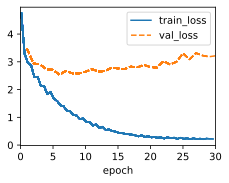

In [ ]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    d2l.GRU, len(data.src_vocab), embed_size, num_hiddens, num_layers=num_layers, dropout=dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Prediction

To predict the output sequence
at each step,
the predicted token from the previous
time step is fed into the decoder as an input.
One simple strategy is to sample whichever token
that has been assigned by the decoder the highest probability
when predicting at each step.
As in training, at the initial time step
the beginning-of-sequence ("&lt;bos&gt;") token
is fed into the decoder. When the end-of-sequence ("&lt;eos&gt;") token is predicted, the prediction of the output sequence is complete.

<!--![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/seq2seq-predict.svg?raw=1)-->



## Evaluation of Predicted Sequences

<!-- We can evaluate a predicted sequence
by comparing it with the
target sequence (the ground truth).
But what precisely is the appropriate measure
for comparing similarity between two sequences?


Bilingual Evaluation Understudy (BLEU),
though originally proposed for evaluating
machine translation results :cite:`Papineni.Roukos.Ward.ea.2002`,
has been extensively used in measuring
the quality of output sequences for different applications.
In principle, for any $n$-gram (:numref:`subsec_markov-models-and-n-grams`) in the predicted sequence,
BLEU evaluates whether this $n$-gram appears
in the target sequence.

Denote by $p_n$ the precision of an $n$-gram,
defined as the ratio
of the number of matched $n$-grams in
the predicted and target sequences
to the number of $n$-grams in the predicted sequence.
To explain, given a target sequence $A$, $B$, $C$, $D$, $E$, $F$,
and a predicted sequence $A$, $B$, $B$, $C$, $D$,
we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.
Now let $\textrm{len}_{\textrm{label}}$ and $\textrm{len}_{\textrm{pred}}$
be the numbers of tokens in the target sequence
and the predicted sequence, respectively.
Then, BLEU is defined as

$$ \exp\left(\min\left(0, 1 - \frac{\textrm{len}_{\textrm{label}}}{\textrm{len}_{\textrm{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

where $k$ is the longest $n$-gram for matching.

Based on the definition of BLEU in :eqref:`eq_bleu`,
whenever the predicted sequence is the same as the target sequence, BLEU is 1.
Moreover,
since matching longer $n$-grams is more difficult,
BLEU assigns a greater weight
when a longer $n$-gram has high precision.
Specifically, when $p_n$ is fixed,
$p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).
Furthermore,
since
predicting shorter sequences
tends to yield a higher $p_n$ value,
the coefficient before the multiplication term in :eqref:`eq_bleu`
penalizes shorter predicted sequences.
For example, when $k=2$,
given the target sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$,
although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU. -->

We implement the BLEU measure as follows.


In [ ]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In the end,
we use the trained RNN encoder-decoder
to translate a few English sentences into French and compute the BLEU of the results.


In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['tom', 'a', 'gagné', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


## Exercises
<!--
1. Can you adjust the hyperparameters to improve the translation results?
1. Rerun the experiment without using masks in the loss calculation. What results do you observe? Why?
1. If the encoder and the decoder differ in the number of layers or the number of hidden units, how can we initialize the hidden state of the decoder?
1. In training, replace teacher forcing with feeding the prediction at the previous time step into the decoder. How does this influence the performance?
1. Rerun the experiment by replacing GRU with LSTM.
1. Are there any other ways to design the output layer of the decoder?-->